# Exploring Generative Image Creation with Deep Convolutional GANs (DCGANs)
##Objective:
Implement a Deep Convolutional Generative Adversarial Network (DCGAN) to generate new images based on a training dataset (e.g., face images, landscapes). Evaluate the quality of the generated images and compare them with real images from the dataset.

## Load Dataset

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d splcher/animefacedataset

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
100% 393M/395M [00:19<00:00, 22.2MB/s]
100% 395M/395M [00:19<00:00, 21.5MB/s]


In [ ]:
!unzip animefacedataset.zip -d anime_face_dataset

Streaming output truncated to the last 5000 lines.
  inflating: anime_face_dataset/images/62764_2019.jpg  
  inflating: anime_face_dataset/images/62765_2019.jpg  
  inflating: anime_face_dataset/images/62766_2019.jpg  
  inflating: anime_face_dataset/images/62767_2019.jpg  
  inflating: anime_face_dataset/images/62768_2019.jpg  
  inflating: anime_face_dataset/images/62769_2019.jpg  
  inflating: anime_face_dataset/images/6276_2003.jpg  
  inflating: anime_face_dataset/images/62770_2019.jpg  
  inflating: anime_face_dataset/images/62771_2019.jpg  
  inflating: anime_face_dataset/images/62772_2019.jpg  
  inflating: anime_face_dataset/images/62773_2019.jpg  
  inflating: anime_face_dataset/images/62774_2019.jpg  
  inflating: anime_face_dataset/images/62775_2019.jpg  
  inflating: anime_face_dataset/images/62776_2019.jpg  
  inflating: anime_face_dataset/images/62777_2019.jpg  
  inflating: anime_face_dataset/images/62778_2019.jpg  
  inflating: anime_face_dataset/images/62779_2019.jpg 

## Import Libraries

In [ ]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

## Import Dataset

In [ ]:
img_width, img_height = 256, 256
batchsize = 32
train = keras. utils.image_dataset_from_directory(
    directory='/content/anime_face_dataset',
    batch_size = batchsize,
    image_size = (img_width, img_height))

Found 63565 files belonging to 1 classes.


## Preprocessing

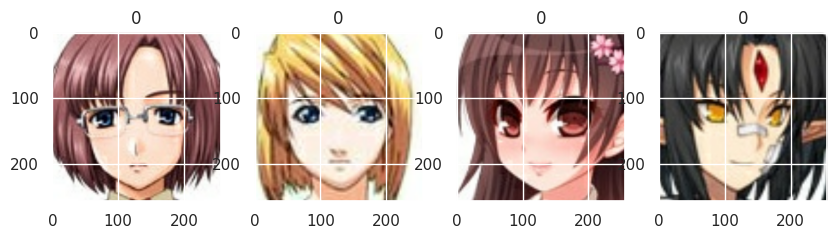

In [ ]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
DIR = '/content/anime_face_dataset'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size = (64, 64),
        batch_size = batchsize,
        class_mode = None)

Found 63565 images belonging to 1 classes.


<html>
<head>
</head>
<body>
  <h1>Deep Convolutional Generative Adversarial Network</h1>
  <p>DCGAN (Deep Convolutional Generative Adversarial Network) is an advanced architecture and training methodology for generative adversarial networks (GANs) specifically designed for image synthesis tasks. It combines deep convolutional neural networks with the adversarial learning framework to generate high-quality and realistic images. </p>
</body>
</html>

### The Generator
  In DCGAN, the generator and discriminator networks play crucial roles. The generator is responsible for generating synthetic images that resemble the target data distribution. It takes random noise as input and gradually transforms it into higher-dimensional outputs using convolutional layers, transposed convolutions, and activation functions like ReLU. Batch normalization is often used to stabilize the learning process.

In [ ]:
KI = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_dim = 300
def Generator_Model():
    Generator = Sequential()
    # Random noise
    Generator.add(Dense(8 * 8 * 512, input_dim = input_dim))
    Generator.add(ReLU())
    # Convert 1d to 3d
    Generator.add(Reshape((8, 8, 512)))
    Generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))
    return Generator
generator = Generator_Model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

  ### The Discriminator
   The discriminator, on the other hand, aims to distinguish between real and generated images. It utilizes convolutional layers, activation functions, and strided convolutions to downsample the spatial dimensions and capture image features. The discriminator is trained to maximize its ability to correctly classify images as real or fake.


In [ ]:
def Discriminator_Model():
    input_shape = (64, 64, 3)
    discriminator = Sequential()
    discriminator.add(Conv2D(64,kernel_size=(3, 3), activation='relu', input_shape = input_shape))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Flatten())
    discriminator.add(Dense(256, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator
discriminator = Discriminator_Model()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,730,625 (10.42 MB)

 Trainable params: 2,730,625 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim = input_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

<html>
<head>
</head>
<body>
  <h1> The Monitoring process </h1>
  <p> To monitor the training progress, callbacks like the DCGANMonitor can be used. This callback generates images from random noise using the trained generator and visualizes them. Additionally, the generator can be saved at the end of training for future use. </p>
</body>
</html>



In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim = input_dim):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs = None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 255) + 255
        g_img.numpy()

    def on_train_end(self, logs = None):
        self.model.generator.save('DCGEN.h5')

## Train the model

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = 300 )
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0003, beta_1= 0.5), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.5), loss_fn = BinaryCrossentropy())
history = dcgan.fit(train_generator, epochs=30, callbacks=[DCGANMonitor()])

Epoch 1/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 63s 26ms/step - d_loss: 0.3192 - g_loss: 2.3246
Epoch 2/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 23ms/step - d_loss: 0.2850 - g_loss: 2.9497
Epoch 3/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - d_loss: 0.2664 - g_loss: 3.0981
Epoch 4/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - d_loss: 0.2601 - g_loss: 3.4352
Epoch 5/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - d_loss: 0.2620 - g_loss: 3.4220
Epoch 6/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - d_loss: 0.3282 - g_loss: 3.3177
Epoch 7/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - d_loss: 0.3570 - g_loss: 2.9287
Epoch 8/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - d_loss: 0.5517 - g_loss: 2.2920
Epoch 9/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - d_loss: 0.3951 - g_loss: 2.7157
Epoch 10/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - d_loss: 0.4023 - g_loss: 2.6831
Epoch 11/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - d_loss: 0.4247 - g_loss: 2.5203
Epoch 12

## Model Evaluation

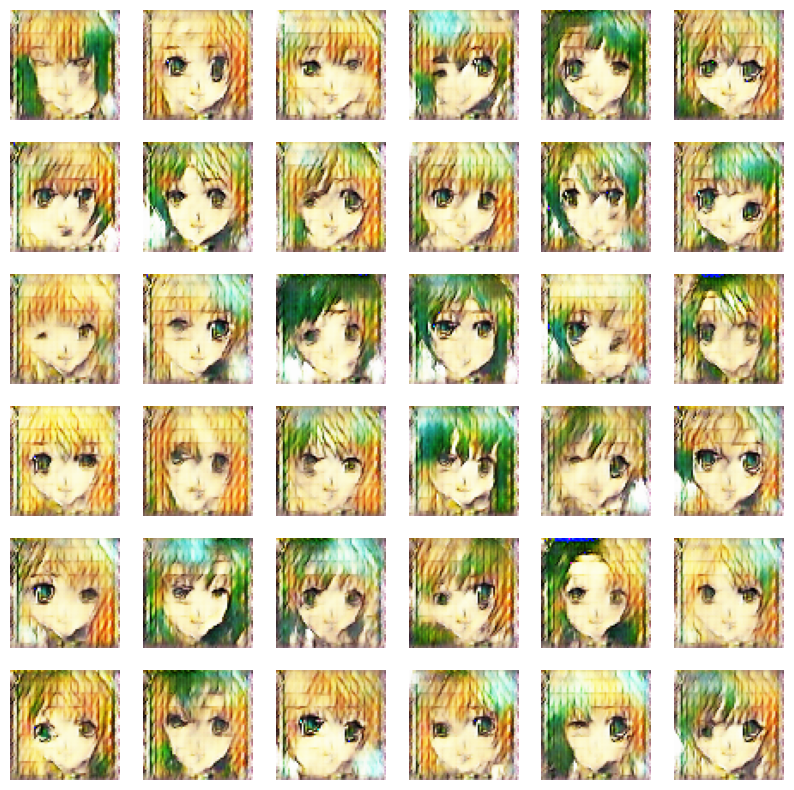

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 300])
    mg = dcgan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))
    plt.imshow(image)
    plt.axis('off')
plt.show()

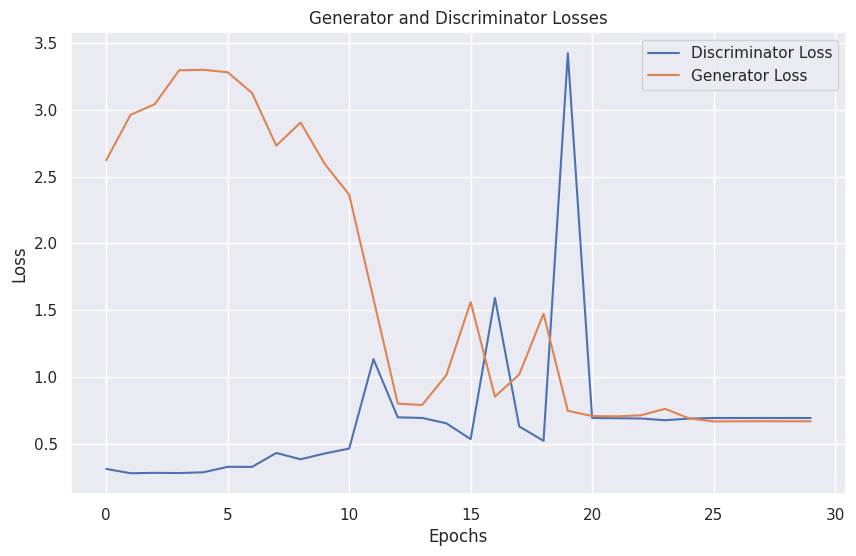

In [ ]:
import matplotlib.pyplot as plt
# Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']

# Call the create_loss_figure function with the loss values
create_loss_figure(d_loss_values, g_loss_values)

## Compare Original Images and Generated Image

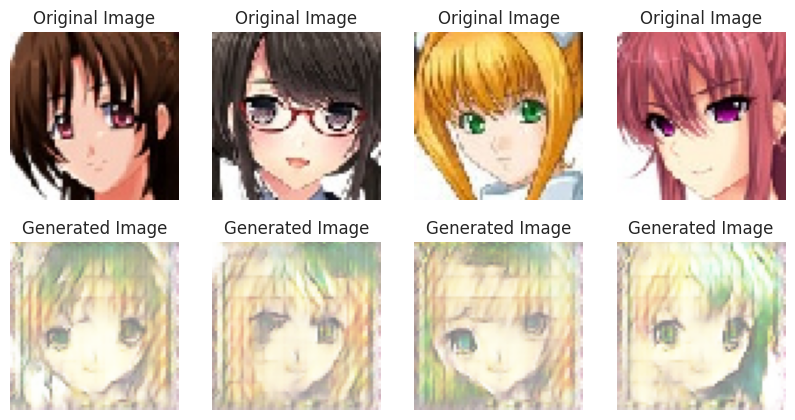

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

original_images = next(train_generator)
for idx in range(4):
    axes[0, idx].imshow(original_images[idx])
    axes[0, idx].set_title("Original Image")
    axes[0, idx].axis('off')

for idx in range(4):
    noise = tf.random.normal([1, 300])
    generated_image = dcgan.generator(noise, training=False)
    generated_image = (generated_image[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    axes[1, idx].imshow(generated_image)
    axes[1, idx].set_title("Generated Image")
    axes[1, idx].axis('off')
plt.show()

## **Conclusion:**
1. **Basic Structure and Colors:** Generated images capture general
facial structure and color schemes, showing the model learned basic features from the dataset.
2. **Blurriness and Detail Loss:** Generated images lack sharpness and fine details, with features like eyes and hair appearing blurry and smudged.
3. **Potential Improvements:** More training epochs, architecture adjustments, or advanced GAN techniques (e.g., Progressive Growing or StyleGANs) could enhance detail and realism.